# Bayesian Neural Network (VI) for classification (under Development)

```
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#   Licensed under the Apache License, Version 2.0 (the "License").
#   You may not use this file except in compliance with the License.
#   A copy of the License is located at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   or in the "license" file accompanying this file. This file is distributed
#   on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#   express or implied. See the License for the specific language governing
#   permissions and limitations under the License.
# ==============================================================================
```

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference

### Generate Synthetic Data

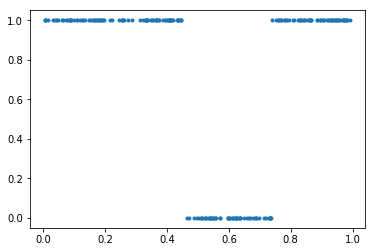

In [2]:
import GPy
%matplotlib inline
from pylab import *

np.random.seed(4)
k = GPy.kern.RBF(1, lengthscale=0.1)
x = np.random.rand(200,1)
y = np.random.multivariate_normal(mean=np.zeros((200,)), cov=k.K(x), size=(1,)).T>0.
plot(x[:,0], y[:,0], '.')

In [3]:
D = 10
net = nn.HybridSequential(prefix='nn_')
with net.name_scope():
    net.add(nn.Dense(D, activation="tanh", flatten=False, in_units=1))
    net.add(nn.Dense(D, activation="tanh", flatten=False, in_units=D))
    net.add(nn.Dense(2, flatten=False, in_units=D))
net.initialize(mx.init.Xavier(magnitude=1))

In [4]:
from mxfusion.components.variables.var_trans import PositiveTransformation
from mxfusion.inference import VariationalPosteriorForwardSampling

In [5]:
m = mf.Model()
m.N = mf.Variable()
m.f = mf.functions.MXFusionGluonFunction(net, num_outputs=1, broadcastable=False)
m.x = mf.Variable(shape=(m.N,1))
m.r = m.f(m.x)
for _,v in m.r.factor.parameters.items():
    v.set_prior(mf.components.distributions.Normal(mean=mx.nd.array([0]),variance=mx.nd.array([3.])))
m.y = mf.distributions.Categorical.define_variable(log_prob=m.r, shape=(m.N,1), num_classes=2)
print(m)

Variable(e06bd) ~ Normal(mean=Variable(78b11), variance=Variable(961fd))
Variable(5f8c9) ~ Normal(mean=Variable(34ce9), variance=Variable(a783a))
Variable(d2e00) ~ Normal(mean=Variable(6bda0), variance=Variable(7f89e))
Variable(b44a6) ~ Normal(mean=Variable(6b08c), variance=Variable(93b41))
Variable(d3cf6) ~ Normal(mean=Variable(ad287), variance=Variable(6700e))
Variable(7ab0d) ~ Normal(mean=Variable(160fc), variance=Variable(cbaf9))
r = GluonFunctionEvaluation(nn_input_0=x, nn_dense0_weight=Variable(7ab0d), nn_dense0_bias=Variable(d3cf6), nn_dense1_weight=Variable(b44a6), nn_dense1_bias=Variable(d2e00), nn_dense2_weight=Variable(5f8c9), nn_dense2_bias=Variable(e06bd))
y ~ Categorical(log_prob=r)


In [6]:
from mxfusion.inference import BatchInferenceLoop, create_Gaussian_meanfield, GradBasedInference, StochasticVariationalInference, MAP

In [7]:
observed = [m.y, m.x]
q = create_Gaussian_meanfield(model=m, observed=observed)
alg = StochasticVariationalInference(num_samples=5, model=m, posterior=q, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

In [8]:
infr.initialize(y=mx.nd.array(y), x=mx.nd.array(x))

In [9]:
for v_name, v in m.r.factor.parameters.items():
    uuid = v.uuid
    loc_uuid = infr.inference_algorithm.posterior[uuid].factor.variance.uuid
    a = infr.params.param_dict[loc_uuid].data().asnumpy()
    a[:] = 1e-8
    infr.params[infr.inference_algorithm.posterior[uuid].factor.mean] = net.collect_params()[v_name].data()
    infr.params[infr.inference_algorithm.posterior[uuid].factor.variance] = mx.nd.array(a)

In [10]:
infr.run(max_iter=500, learning_rate=1e-1, y=mx.nd.array(y), x=mx.nd.array(x), verbose=True)

Iteration 51 loss: 1066.1125488281255
Iteration 101 loss: 675.2722167968758
Iteration 151 loss: 345.30307006835945
Iteration 201 loss: 196.68641662597656
Iteration 251 loss: 155.23381042480478
Iteration 301 loss: 149.42289733886724
Iteration 351 loss: 159.71490478515625
Iteration 401 loss: 140.58926391601562
Iteration 451 loss: 174.78173828125438
Iteration 500 loss: 127.64309692382812

In [11]:
for uuid, v in infr.inference_algorithm.posterior.variables.items():
    if uuid in infr.params.param_dict:
        print(v.name, infr.params[v])

None 
[[-4.2562084 ]
 [-2.1897657 ]
 [-2.7514694 ]
 [-1.8618754 ]
 [ 0.05935706]
 [ 2.3460457 ]
 [-2.6491752 ]
 [-1.2179427 ]
 [-0.08034295]
 [-0.5979197 ]]
<NDArray 10x1 @cpu(0)>
None 
[[0.01767311]
 [0.00603309]
 [0.00848725]
 [0.05524571]
 [0.68462664]
 [0.00412718]
 [0.03144019]
 [0.11763541]
 [2.0121076 ]
 [0.37226263]]
<NDArray 10x1 @cpu(0)>
None 
[ 1.6983228   1.4742194   1.775172    0.6392376   0.31661415 -1.6325905
  1.398058    0.7429083   0.04331838  0.3991743 ]
<NDArray 10 @cpu(0)>
None 
[0.00463977 0.00697836 0.00277748 0.04407028 0.45794868 0.00267045
 0.01026547 0.07324851 0.6038953  0.06482685]
<NDArray 10 @cpu(0)>
None 
[[-5.0367075e-01 -3.6483032e-01 -3.4889570e-01 -3.7278756e-01
  -5.8295298e-01  2.0773776e-01 -5.1646495e-01 -5.6319767e-01
   1.2088771e-01 -3.6126822e-02]
 [ 3.2355504e-03 -3.6068845e-01 -1.8626985e-01 -1.8437026e-01
   6.3100457e-04  4.4206291e-01 -2.7084729e-02 -3.1543028e-01
  -2.8092265e-01 -2.6803422e-01]
 [-1.4353344e-01  2.7556152e+00  2.756637

In [12]:
xt = np.linspace(0,1,100)[:,None]

In [13]:
infr2 = VariationalPosteriorForwardSampling(10, [m.x], infr, [m.r])
res = infr2.run(x=mx.nd.array(xt))

In [14]:
yt = res[m.r].asnumpy()

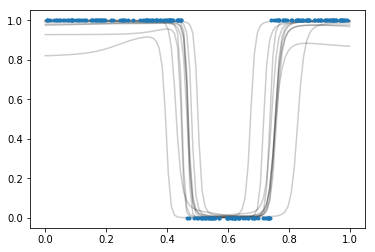

In [15]:
yt_mean = yt.mean(0)
yt_std = yt.std(0)
for i in range(yt.shape[0]):
    plot(xt[:,0],1./(1+np.exp(yt[i,:,0]-yt[i,:,1])),'k',alpha=0.2)
plot(x[:,0],y[:,0],'.')